<h1>CSE483 Computer Vision Major Task</h1>
<h2>Team 1</h2>
<ul>
<li>Youssef George 19p9824</li>
<li>Kerollos Wageeh 19p3468</li>
<li>Nada Amr 19p1621</li>
</ul>

## Import libraries
Use "pip install libName" in terminal if any of them is not installed on your machine.

In [1]:
import pandas as pd
import numpy as np
import cv2
from scipy.io import loadmat
import json
import statistics
import torch
from torchvision import ops
from operator import itemgetter
import random
import tensorflow as tf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [2]:
# CONSTANTS
useCONTRAST = 1
useCLAHE = 0
useOPEN = 0
useCLOSE = 0
useCANNY = 0
cannyTH1 = 150
cannyTH2 = 200

# Fn import pics, labels, true boxes
def getPics(chosen_set):
    images = []
    labels = []
    boxes = []
    
    picsFolder_path = "SVHN/" + chosen_set + "/"
    with open(picsFolder_path + 'digitStruct.json') as f:
        data = json.load(f)

# import colored pictures
    for i in range(len(data)):
        image = cv2.imread(picsFolder_path + data[i]['filename'])
        images.append(image)
        temp=[]
        for j in range(len(data[i]['boxes'])):
            temp.append(data[i]['boxes'][j]['label'])
        temp = np.array(temp)
        labels.append(temp)
        boxes.append(data[i]['boxes'])

    print("There are ", len(data), " images in " + chosen_set + " set.")
    images = np.array(images)
    labels = np.array(labels)
    boxes = np.array(boxes)
    return images, labels, boxes

# Fn performs CV techniques on a single picture
def rectanglesModel(img):
    image = img.copy()
    boxes = []
    
    image = cv2.bilateralFilter(image,11,9,9) 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    if(useCONTRAST):
        cv2.convertScaleAbs(image, image)
        
    if(useCLAHE):
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        image = clahe.apply(image)
        
    bnr = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,1)

    if(useCANNY):
        bnr = cv2.Canny(image, cannyTH1, cannyTH2, 255)
        
    contours, hierarchy = cv2.findContours(bnr, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    for i in range(len(contours)):
        boxes.append({})
        x,y,w,h = cv2.boundingRect(contours[i])
        boxes[i]['left'], boxes[i]['top'], boxes[i]['width'], boxes[i]['height'] = x,y,w,h
        twopointsRec = [x,y,x+w,y+h]
    return boxes

# IOU average accuracy test per picture
def iouPicTest(truth, predicted, threshold1=0.5, threshold2=0.5): 
    filtered = []
    boxesTensors = []
    # Check IOU of predicted against all true boxes
    for i in range(len(truth)):
        for j in range(len(predicted)):
            truth_box = torch.tensor(
                [[truth[i]['left'], truth[i]['top'], truth[i]['left'] + truth[i]['width'],
                  truth[i]['top']+truth[i]['height']]], dtype=torch.float)
            predicted_box = torch.tensor(
                [[predicted[j]['left'], predicted[j]['top'], predicted[j]['left']+predicted[j]['width'],
                  predicted[j]['top']+predicted[j]['height']]], dtype=torch.float)
            x = ops.box_iou(truth_box, predicted_box)
    # Append possible true boxes to "filtered" array
            if (x >= threshold1):
                filtered.append([float(x), predicted[j]])
                boxesTensors.append([predicted[j]['left'], predicted[j]['top'],predicted[j]['left']+predicted[j]['width'],predicted[j]['top']+predicted[j]['height']])
    
    
    # Apply Non-maximum suppression to get 0/1 corresponding predicted box for every true box
    acc=0
    selected_boxes = []
    if len(filtered) > 0:
        scoresTensors = tf.convert_to_tensor(np.array(np.array(filtered).T[0],dtype=np.float16))
        boxesTensors = torch.tensor(boxesTensors)
        selected_indices = tf.image.non_max_suppression(boxesTensors,scoresTensors,15,threshold2)
        selected_boxes = tf.gather(boxesTensors,selected_indices)
        selected_scores = tf.gather(scoresTensors,selected_indices)
        acc = np.sum(np.array(selected_scores))/len(truth)
    return acc, selected_boxes
    
    # filtered = sorted(filtered, key=itemgetter(0), reverse=True)
    # i=0
    # acc = 0
    # iou = []
    # if len(filtered) > 0:
    #     while i < len(filtered) and filtered[i][0] != 0 :
    #         for j in range(i+1, len(filtered)):
    #             predicted_box1 = torch.tensor(
    #             [[filtered[i][1]['left'], filtered[i][1]['top'], filtered[i][1]['left']+filtered[i][1]['width'],
    #               filtered[i][1]['top']+filtered[i][1]['height']]], dtype=torch.float)
    #             predicted_box2 = torch.tensor(
    #             [[filtered[j][1]['left'], filtered[j][1]['top'], filtered[j][1]['left']+filtered[j][1]['width'],
    #               filtered[j][1]['top']+filtered[j][1]['height']]], dtype=torch.float)
    #             if (ops.box_iou(predicted_box1, predicted_box2)) >= threshold2:
    #                 filtered[j][0]= 0
    #         i+=1
    #         filtered = sorted(filtered, key=itemgetter(0), reverse=True)
    #     cnt=0
        
    # # Calculate weighted average IOU accuracy of filtered boxes
    #     for i in range(len(filtered)):
    #         if (filtered[i][0]==0):
    #             break
    #         cnt+=1
    #         iou.append(filtered[i][0])
    #     acc = np.sum(np.array(iou))/len(truth)
    #     filtered = filtered[:cnt]
    # return acc, filtered
    
def showRectangles(image, rectangles, title=""):
    image2 = image.copy()
    for i in rectangles:
        cv2.rectangle(image2, (i['left'], i['top']), (i['left'] +
                      i['width'], i['top']+i['height']), (0, 255, 0), 1)
    plt.figure()
    plt.title(title)
    plt.imshow(image2)

def getPictureIOUAccuracy(image, box):
    image = image.copy()
    predicted_boxes = rectanglesModel(image)
    true_boxes = box.copy()
    accuracy, ret = (iouPicTest(true_boxes,predicted_boxes))
    return accuracy

def getAllIOUAccuracy(images, boxes):
    all_accuracy = []
    for i in range(len(images)):
        all_accuracy.append(getPictureIOUAccuracy(images[i],boxes[i]))
    acc = np.average(np.array(all_accuracy))
    return acc

In [3]:
train_images_all, train_labels_all, train_boxes_all = getPics("train")

There are  33402  images in train set.


In [ ]:
test_images_all, test_labels_all, test_boxes_all = getPics("test")

There are  13068  images in test set.


In [30]:
extra_images_all, extra_labels_all, extra_boxes_all = getPics("extra")

KeyboardInterrupt: 

In [4]:
n = 2000
train_images = train_images_all[n:2*n]
train_labels = train_labels_all[n:2*n]
train_boxes = train_boxes_all[n:2*n]
print(train_boxes[0])

[{'height': 34.0, 'label': 3.0, 'left': 37.0, 'top': 5.0, 'width': 14.0}]


### Algorithm steps on sample random image image

- Choose random image from dataset:

Picture number:  16752
Labels:
5.0
6.0


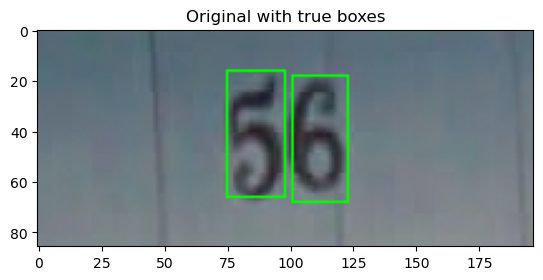

In [17]:
# choose random image from dataset
idx = random.randint(0, len(train_images_all)-1)
trialImage = train_images_all[idx].copy()
print("Picture number: ", idx+1)
print("Labels:")
plt.title("Original with true boxes")
imgBoxes = trialImage.copy()
for i in train_boxes_all[idx]:
    print(i['label'])
    cv2.rectangle(imgBoxes,
                  (int(i['left']),int(i['top'])),
                  (int(i['left'])+int(i['width']),int(i['top'])+int(i['height'])),
                  (0,255,0), 1)
plt.imshow(imgBoxes)


- Step 1: Bilateral filter smoothes all pic except edges

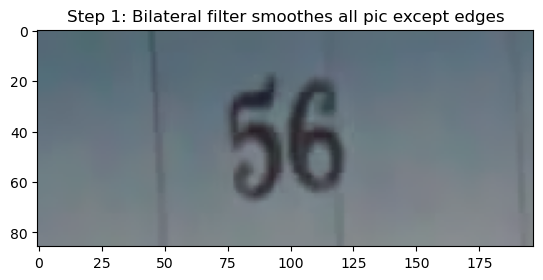

In [18]:
image = cv2.bilateralFilter(trialImage,11,9,9) 
plt.imshow(image)
plt.title("Step 1: Bilateral filter smoothes all pic except edges")
plt.show()

- Step 2: Convert to gray scale

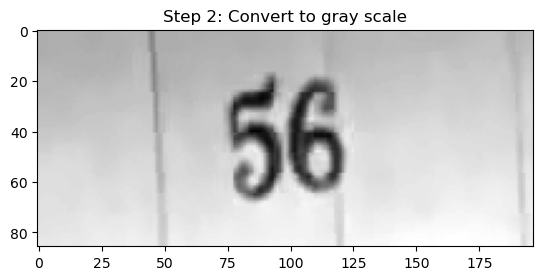

In [19]:
image = cv2.cvtColor(image.copy(),cv2.COLOR_BGR2GRAY)
plt.imshow(image, cmap='gray')
plt.title("Step 2: Convert to gray scale")
plt.show()

- Step 3: Enhance picture contrast

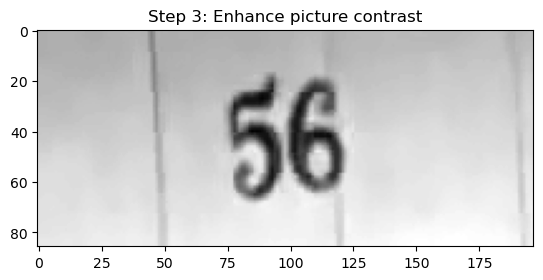

In [20]:
cv2.convertScaleAbs(image, image)
plt.imshow(image, cmap='gray')
plt.title("Step 3: Enhance picture contrast")
plt.show()

- Step 4: Apply adaptive thresholding

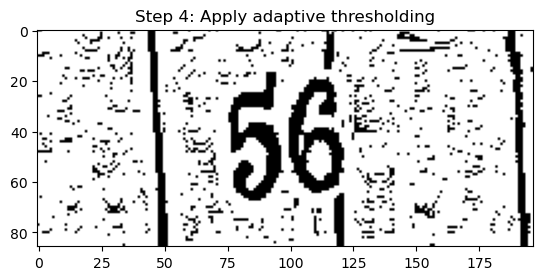

In [21]:
bnr = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,1)
plt.imshow(bnr, cmap='gray')
plt.title("Step 4: Apply adaptive thresholding")
plt.show()


- Step 5: (optional) Opening using 3x3 kernel

useOPEN =  0


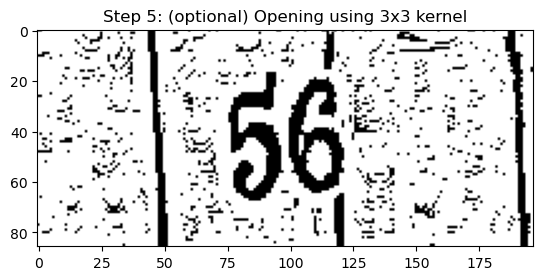

In [22]:
useOPEN = useOPEN
kernel = np.ones((3, 3), np.uint8)
print("useOPEN = ", useOPEN)
if(useOPEN):
    bnr = cv2.morphologyEx(bnr, cv2.MORPH_OPEN,
                           kernel, iterations=1)
plt.imshow(bnr,cmap='gray')
plt.title("Step 5: (optional) Opening using 3x3 kernel")
plt.show()

useCLOSE =  0


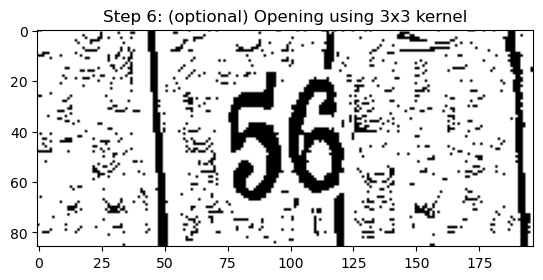

In [70]:
useCLOSE = useCLOSE
print("useCLOSE = ",useCLOSE)
if(useCLOSE):
    bnr = cv2.morphologyEx(bnr, cv2.MORPH_CLOSE,
                           kernel, iterations=1)
plt.figure()
plt.imshow(bnr, cmap='gray')
plt.title("Step 6: (optional) Opening using 3x3 kernel")
plt.show()

- Step 7: Canny edge detection

useCANNY =  0


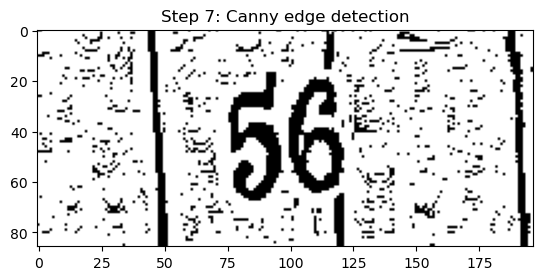

In [24]:
print("useCANNY = ",useCANNY)
if(useCANNY):
    print("Threshold1: ", cannyTH1)
    print("Threshold2: ", cannyTH2)
    bnr = cv2.Canny(bnr, cannyTH1, cannyTH2, 255)
plt.figure()
plt.imshow(bnr, cmap='gray')
plt.title("Step 7: Canny edge detection")
plt.show()

- Step 8: Extract contours

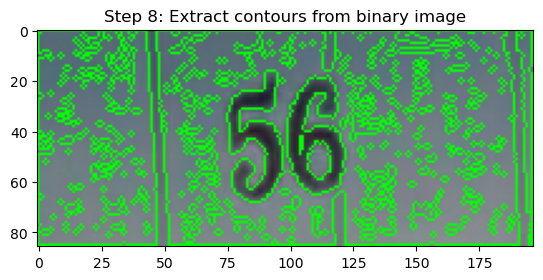

In [25]:
contours, hierarchy = cv2.findContours(bnr, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
temp = trialImage.copy()
cv2.drawContours(temp,contours,-1,color=(0,255,0),thickness=1)
plt.imshow(temp)
plt.title("Step 8: Extract contours from binary image")
plt.show()

- Step 9: Draw Rectangles around contours

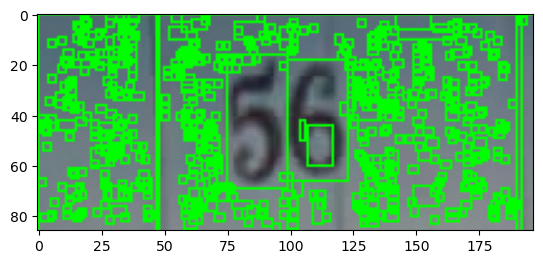

In [26]:
temp = trialImage.copy()
for i in range(len(contours)):    
        x,y,w,h = cv2.boundingRect(contours[i])
        cv2.rectangle(temp,
                  (x,y),
                  (x+w,y+h),
                  (0,255,0), 1)
plt.imshow(temp)

In [75]:
# i=i
print("Picture filename:",idx,".png")
print(train_labels_all[idx])
predicted_boxes = rectanglesModel(train_images_all[idx])
true_boxes = train_boxes_all[idx]
accuracy, ret = (iouPicTest(true_boxes,predicted_boxes))
print("Picture average IOU accuracy:",accuracy*100,"%")
print(len(ret),"true boxes predicted out of", len(true_boxes))

Picture filename: 16751 .png
[5. 6.]
[[[176  84]]

 [[177  83]]

 [[178  84]]

 [[177  85]]]
Picture average IOU accuracy: 89.35546875 %
2 true boxes predicted out of 2


## Average accuracy of all pictures:

In [5]:
print(len(train_images), "pictures are under testing")
all_acc = getAllIOUAccuracy(train_images, train_boxes)
print("Accuracy: ", all_acc*100, "%")

2000 pictures are under testing
Accuracy:  47.31485799153646 %


------------------------------------------------------------------

## Model that visualize biggest convex hull

In [ ]:
def hullModel(img):
    image = img.copy()
    g = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edged = cv2.Canny(g, 1, 5, 255)
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    #cnts = sorted(contours, key=cv2.contourArea, reverse=True)
    hulls = []
    for i in range(len(contours)):
        hulls.append(cv2.convexHull(contours[i]))
        # cv2.drawContours(toDraw, [hull], 0, (0, 255, 0), 1)
    return hulls


Label:  [2. 3.]


NameError: name 'hullModel' is not defined

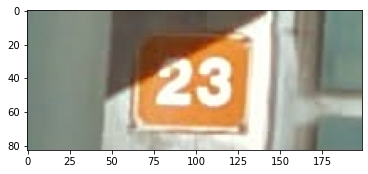

<Figure size 432x288 with 0 Axes>

In [212]:
i=1
print("Label: ", train_labels[i])
plt.figure("Original")
plt.imshow(train_images[i])
plt.figure("Hull Model")
hulls = hullModel(train_images[i])
for j in range(len(hulls)):
    toDraw = train_images[i].copy()
    cv2.drawContours(toDraw, [hulls[j]], 0, (0, 255, 0), 1)
plt.imshow(toDraw)

# plt.imshow(ans)


-----------------------------------------------------------------------

- View sample image

sample train image of lable(s):  [2. 3.]


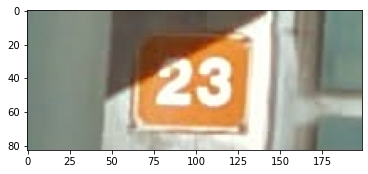

In [213]:
i = 1
print("sample train image of lable(s): ",train_labels[i] )
plt.imshow(train_images[i])
plt.show()

- Convert to grayscale

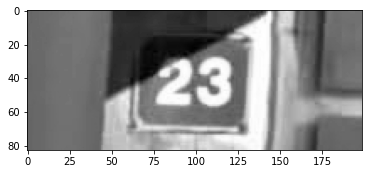

In [214]:
gray = cv2.cvtColor(train_images[i],cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
plt.show()

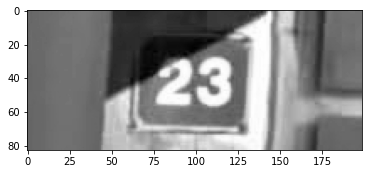

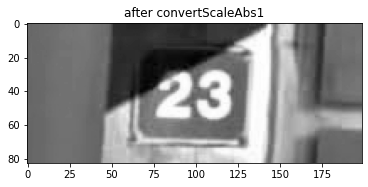

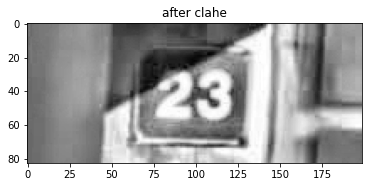

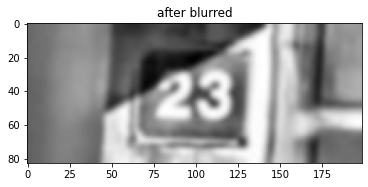

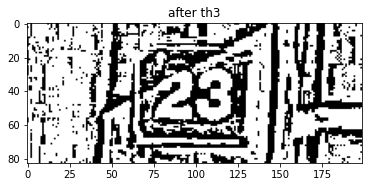

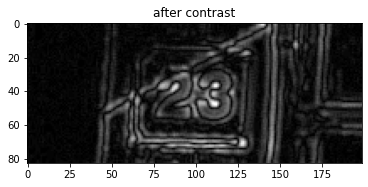

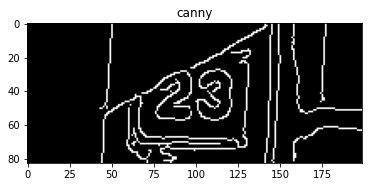

In [215]:
plt.imshow(gray, cmap='gray')
plt.show()

cv2.convertScaleAbs(gray, gray)
plt.figure()
plt.imshow(gray, cmap='gray')
plt.title("after convertScaleAbs1")
plt.show()

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
equalized = clahe.apply(gray)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
equalized = clahe.apply(gray)
plt.figure()
plt.imshow(equalized, cmap='gray')
plt.title("after clahe")
plt.show()

blurred = cv2.GaussianBlur(equalized, (7, 7), 0)
plt.figure()
plt.imshow(blurred, cmap='gray')
plt.title("after blurred")
plt.show()

th3 = cv2.adaptiveThreshold(equalized,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
plt.figure()
plt.imshow(th3, cmap='gray')
plt.title("after th3")
plt.show()

sharpened = cv2.convertScaleAbs(cv2.Laplacian(blurred, cv2.CV_16S, ksize=3))
plt.figure()
plt.title("after contrast")
plt.imshow(sharpened, cmap='gray')
plt.show()

edged = cv2.Canny(blurred, 50, 150, 255)
plt.figure()
plt.title("canny")
plt.imshow(edged, cmap='gray')
plt.show()

# lines = cv2.HoughLines(edged, 1, np.pi/180, 30)

# temp = np.zeros((gray.shape[0], gray.shape[1], 3))
# for rho,theta in lines[0]:
#     a = np.cos(theta)
#     b = np.sin(theta)
#     x0 = a*rho
#     y0 = b*rho
#     x1 = int(x0 + 1000*(-b))
#     y1 = int(y0 + 1000*(a))
#     x2 = int(x0 - 1000*(-b))
#     y2 = int(y0 - 1000*(a))

#     cv2.line(temp,(x1,y1),(x2,y2),(0,0,255),2)
# plt.figure()
# plt.title("hough")
# plt.imshow(temp, cmap='gray')
# plt.show()

# temp = np.zeros((gray.shape[0], gray.shape[1], 3))
# linesP = cv2.HoughLinesP(sharpened,1,np.pi/180,50, None,10,1)
# if linesP is not None:
#     for i in range(0, len(linesP)):
#         l = linesP[i][0]
#         cv2.line(temp, (l[0], l[1]), (l[2], l[3]), (0, 0, 255), 3, cv2.LINE_AA)

# plt.figure()
# plt.title("hough2")
# plt.imshow(temp)
# plt.show() 

# contours, hierarchy = cv2.findContours(
#     edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
# contours = sorted(contours, key=cv2.contourArea, reverse=True)
# for i in range(10):
#     temp = np.zeros((gray.shape[0], gray.shape[1], 3))
#     cv2.drawContours(temp, contours[i], -1, (255, 255, 255), 1)
#     plt.figure()
#     plt.title("after edges")
#     plt.imshow(temp, cmap='gray')
#     plt.show()


- Gaussian blur

In [ ]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plt.imshow(blurred, cmap='gray')
plt.show()

- Canny edge detection

In [ ]:
edged = cv2.Canny(gray, 20, 100, 255)
edged_smoothed = cv2.GaussianBlur(edged, (5, 5), 0)

plt.imshow(edged_smoothed, cmap='gray')
plt.show()


- Finding countours

In [ ]:
contours, hierarchy  = cv2.findContours(edged_smoothed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
x = np.zeros((edged.shape[0], edged.shape[1], 3))
for i in range(len(contours)):
    temp = np.zeros((edged.shape[0], edged.shape[1], 3))
    cv2.drawContours(temp, contours, i, (255,255,255), 1, lineType = cv2.LINE_8)
    cv2.drawContours(x, contours, i, (255,255,255), 1, lineType = cv2.LINE_8)
    plt.imshow(temp)
    plt.show()
plt.imshow(x)
plt.show()
x = cv2.convexHull(contours)
plt.imshow(x)
plt.show()

In [ ]:
# find contours in the edge map, then sort them by their size in descending order
# cnts = imutils.grab_contours(contours)
cnts = sorted(contours, key=cv2.contourArea, reverse=True)
img = train_images[i].copy()
i = 0

for j in cnts:
    if (cv2.isContourConvex(j) and i < 4):
        img = cv2.drawContours(img, j, -1, (0, 255, 75), 2)
        print(cv2.contourArea(j))
        i += 1
plt.imshow(img)
plt.show()

# displayCnt = None
# loop over the contours
# for c in cnts:
# 	# approximate the contour
# 	peri = cv2.arcLength(c, True)
# 	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
# 	# if the contour has four vertices, then we have found the thermostat display
# 	if len(approx) == 4:
# 		displayCnt = approx
# 		break


In [ ]:
i = 2
print("sample cropped train image of lable(s): ",cropped_train_labels[i] )
plt.imshow(cropped_train_images[i])
plt.show()

In [ ]:
gray = cv2.cvtColor(cropped_train_images[i],cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
plt.show()

In [ ]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plt.imshow(blurred, cmap='gray')
plt.show()

In [ ]:
edged = cv2.Canny(blurred, 40, 100, 255)
plt.imshow(edged, cmap='gray')
plt.show()

In [ ]:
for i in range(10):
    plt.imshow(cropped_train_images[i, :, :, :])
    plt.show()
    print(cropped_train_labels[i])